In [1]:
# Python 3.9.9
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2023-09-26 22:26:10.996156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 22:26:10.998379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 22:26:11.035140: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 22:26:11.035919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 22:26:12.888446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

scanpy==1.9.3 anndata==0.8.0 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.5


In [3]:
DATA_PATH = 'scGND/data/traj_data_real/oligodendrocyte-differentiation-subclusters_marques'


# Load data

In [4]:
# Read the CSV file
counts = pd.read_csv(DATA_PATH+"_count.csv",index_col=0)

genes = np.array(counts.columns)
cells = np.array(counts.index)
counts_np = np.array(counts)

print(counts_np.shape)

(4930, 3534)


In [5]:
cluster_labels = pd.read_csv(DATA_PATH+"_clusters.csv",index_col=0)
print(cluster_labels)
cluster_np = np.squeeze(np.array(cluster_labels))

cluster_unq = np.unique(cluster_np)
n = 0
for it in cluster_unq:
    cluster_np[cluster_np==it] = n
    n+=1
cluster_np_unq = np.unique(cluster_np)
print(cluster_np.shape)
print(cluster_unq)
print(cluster_np_unq)

                        x
C1-1771017-028-D03    OPC
C1-1771017-028-E03    OPC
C1-1771017-028-F08    OPC
C1-1771017-028-G05    OPC
C1-1771017-028-G10    OPC
...                   ...
C1-1862091-118-C05  MFOL2
C1-1862091-118-C07  MFOL2
C1-1862091-118-D10  NFOL2
C1-1862091-118-E08    OPC
C1-1862091-118-F09  NFOL2

[4930 rows x 1 columns]
(4930,)
['COP' 'MFOL1' 'MFOL2' 'MOL1' 'MOL2' 'MOL3' 'MOL4' 'MOL5' 'MOL6' 'NFOL1'
 'NFOL2' 'OPC']
[0 1 2 3 4 5 6 7 8 9 10 11]


In [6]:
obs = pd.DataFrame({}, index=cells)
var = pd.DataFrame({}, index=genes)

adata = sc.AnnData(X=counts_np, obs=obs, var=var)

clusters = np.squeeze(np.array(cluster_np)).astype(str)
adata.obs['labels'] = clusters

/scratch/1309944.1.iris-gpu-pub/ipykernel_1713572/4272853244.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=counts_np, obs=obs, var=var)


In [7]:
adata

AnnData object with n_obs × n_vars = 4930 × 3534
    obs: 'labels'

# Preprocessing

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

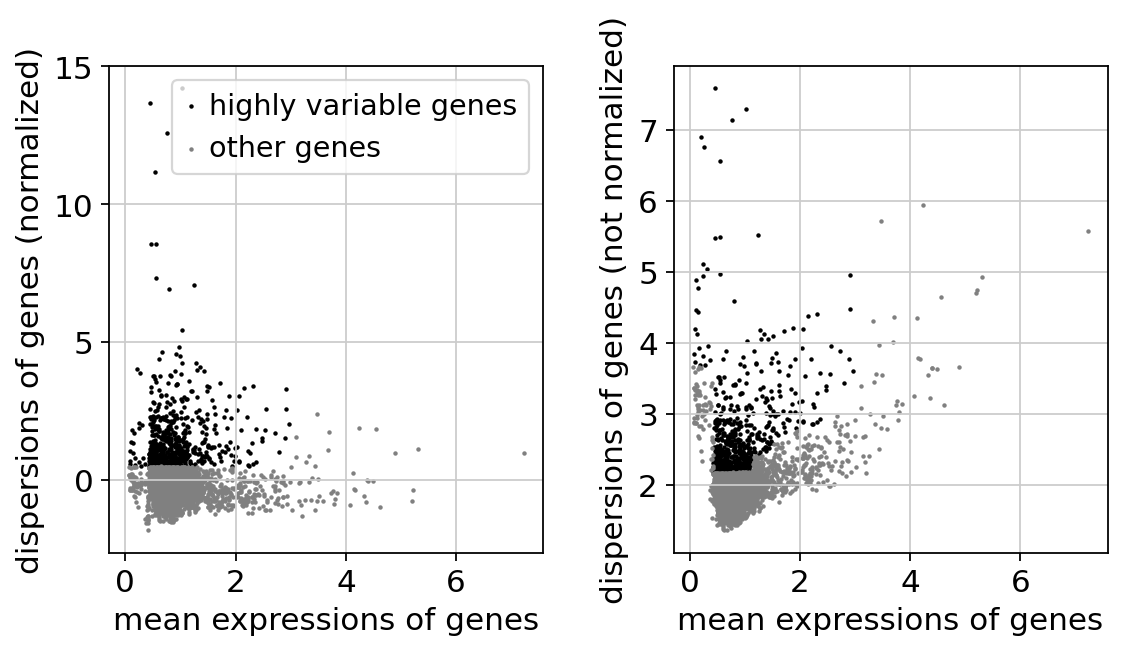

In [11]:
sc.pl.highly_variable_genes(adata)

In [12]:
adata.raw = adata

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

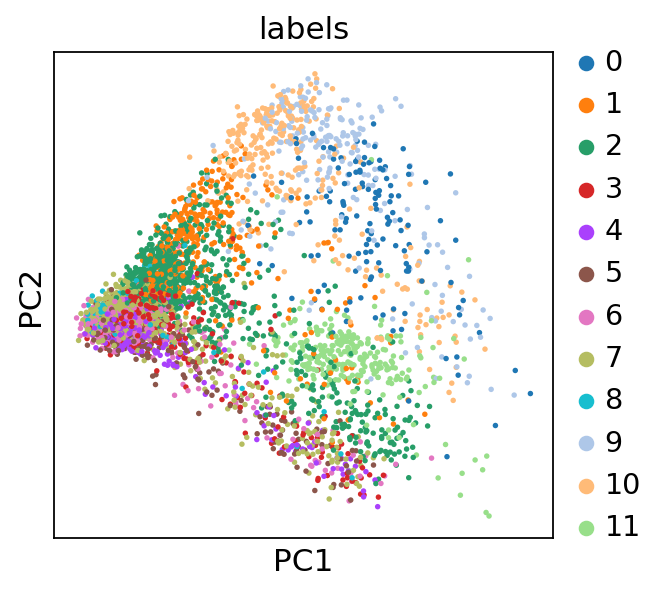

In [14]:
sc.pl.pca(adata, color='labels')

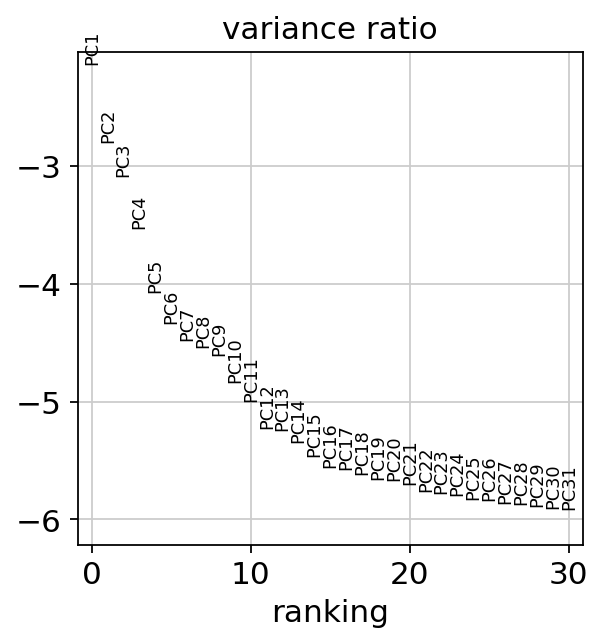

In [15]:
sc.pl.pca_variance_ratio(adata, log=True)

In [16]:
#adata.write(OUTPUT_PATH+results_file)

In [17]:
#adata = sc.read_h5ad(OUTPUT_PATH+results_file)

In [18]:
# Find neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/share/pkg.7/python3/3.9.9/install/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [19]:
sc.tl.umap(adata)

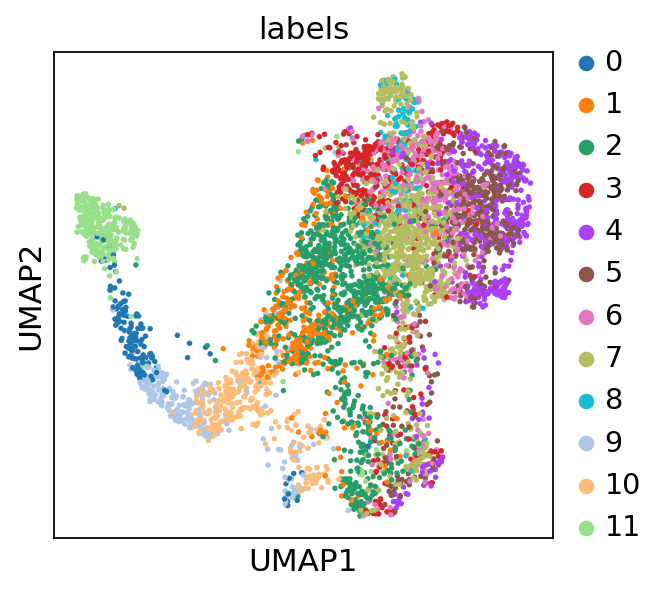

In [20]:
sc.pl.umap(adata, color=['labels'])

# Trajectory

In [22]:
sc.tl.paga(adata, groups='labels')

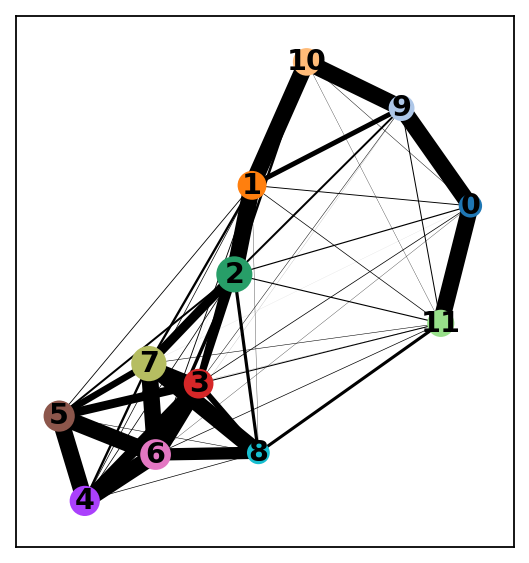

In [24]:
sc.pl.paga(adata, threshold=0.0, show = True)

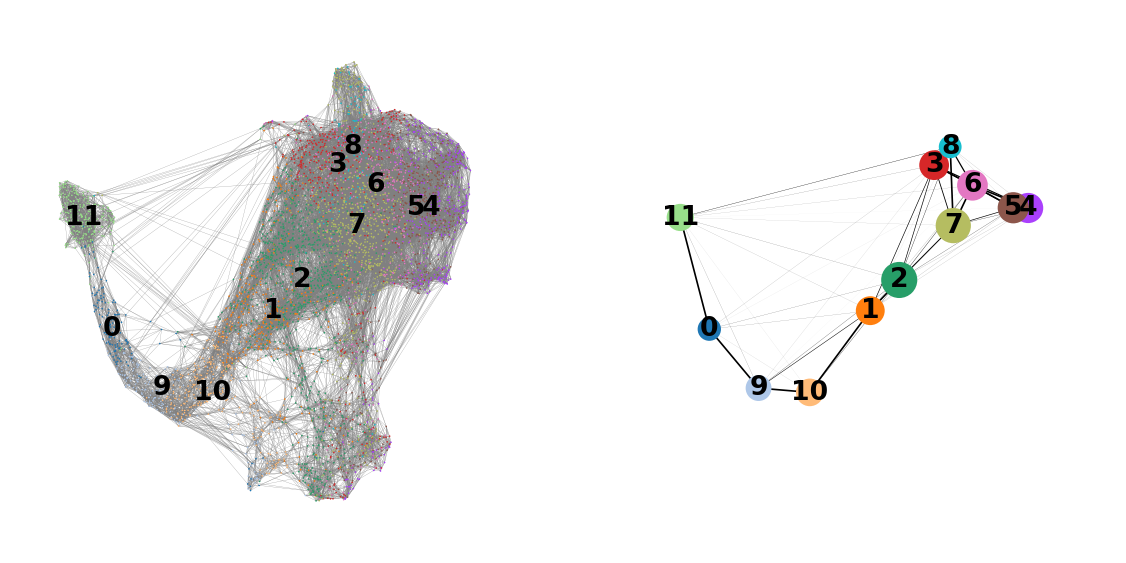

In [26]:
sc.pl.paga_compare(
    adata, threshold=0.0, title='', right_margin=0.2, size=2, edge_width_scale=0.1,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

In [27]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['labels']  == '11')[0]

sc.tl.dpt(adata)

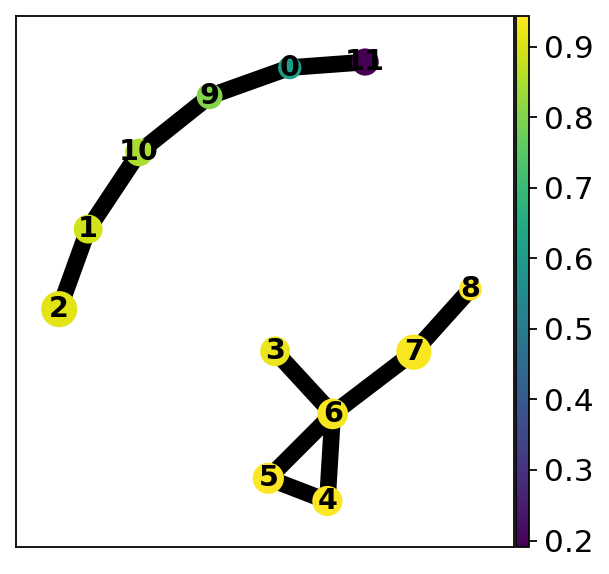

In [32]:
sc.pl.paga(adata, threshold=1.0, color=['dpt_pseudotime'])